In [66]:
import sys, itertools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn, time, math
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix

if '../tools' not in sys.path:
    sys.path.append('../tools')
from helper_functions import * 

import warnings
warnings.filterwarnings('ignore')

Using existing FVs from file ../generated-fv/FVC8-3.mat
N = 1000
chroma training feature ranges means [-0.0079, 0.0084] sds [0.0170, 0.0492]


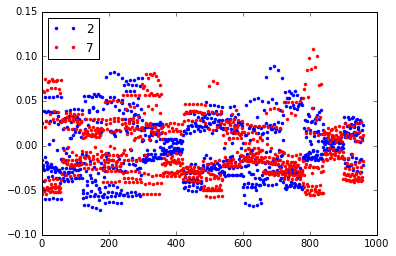

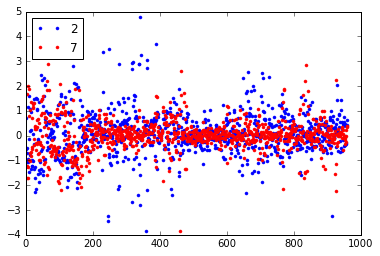

Train shape (900, 960) riffled (900, 960)
Test shape (100, 960) riffled (100, 960)
Default SVM perf orig 0.53 riff 0.5


In [24]:
num_clusters, exemplar = 8, 3
X, Y = load_chroma_fv(num_clusters, exemplar) #load_all_fv(num_clusters, exemplar)

T = num_clusters * 2
t = (exemplar - (1 if exemplar % 2 == 0 else 0)) * 2 - 1

trX, teX, trY, teY = train_test_split((X, Y), stratify=Y,
                                      random_state=0, test_size=0.1)
axes = plt.subplots()[1]
idx = np.where(trY != trY[0])[0][1]
#idx = np.where(trY == trY[0])[0][1] # same label
axes.plot(trX[0], c='b', marker='.', linestyle='', label=trY[0])
axes.plot(trX[idx], c='r', marker='.', linestyle='', label=trY[idx])
axes.legend(loc=2)

def whiten_train_test(train, test):
    return whiten(train), whiten(test, source=train)
trXadj, teXadj = whiten_train_test(trX, teX)
def modify(x, t, T):
    riffled = riffle(x, t, T)
    avgs = np.average(riffled, axis=2)
    N = (t-1) * (x.shape[1] // t)
    riffled = riffled[:, :, :-1].reshape(len(x), N)
    rep = np.repeat(avgs, t-1).reshape(len(x), N)
    return np.concatenate([avgs, riffled - rep], axis=1)
trXrff, teXrff = whiten_train_test(*((modify(x, t, T) for x in (trX, teX))))
axes = plt.subplots()[1]
axes.plot(trXrff[0], c='b', marker='.', linestyle='', label=trY[0])
axes.plot(trXrff[idx], c='r', marker='.', linestyle='', label=trY[idx])
axes.legend(loc=2)

plt.show()

print('Train shape {} riffled {}'.format(trXadj.shape, trXrff.shape))
print('Test shape {} riffled {}'.format(teXadj.shape, teXrff.shape))
print('Default SVM perf orig {} riff {}'.format(
        SVC(C=1.0).fit(trXadj, trY).score(teXadj, teY),
        SVC(C=1.0).fit(trXrff, trY).score(teXrff, teY)))

# no missing data

In [64]:
num_clusters, exemplar = 8, 3
T = num_clusters * 2
t = (exemplar - (1 if exemplar % 2 == 0 else 0)) * 2 - 1
X, Y = load_all_fv(num_clusters, exemplar) #load_all_fv(num_clusters, exemplar)
C, Y = load_chroma_fv(14, 11)
X = np.concatenate((X, C), axis=1)

Using existing FVs from file ../generated-fv/FV8-3.mat
N = 1000
MFCC training feature ranges means [-0.0119, 0.0060] sds [0.0119, 0.0429]
Using existing FVs from file ../generated-fv/FVC14-11.mat
N = 1000
chroma training feature ranges means [-0.0045, 0.0025] sds [0.0038, 0.0176]


In [ ]:
def log_range(lo, hi): return [10 ** i for i in range(lo, hi)]

def runIterative(X, Y, hypers, classifier):
    hypers = list(hypers)
    best_acc, best_params = -np.inf, None
    t = time.time()
    skf = StratifiedKFold(Y, n_folds=3, shuffle=True, random_state=1)
    for i, C in enumerate(hypers):
        svm = classifier(C)
        score = np.average(cross_val_score(svm, X, Y, cv=skf, n_jobs=-1))
        if score > best_acc:
            best_acc = score
            best_params = C
        print('\r{} best acc {:03g} hyper {}'.format(
                completion_bar(i + 1, len(hypers), width=20),
                best_acc, best_params), end='')
        sys.stdout.flush()
    t = time.time() - t
    print('\ndone in', t,'seconds')
    return best_acc, best_params

import multiprocessing
def get_score(tup):
    C, X, Y, classifier, data_change, skf = tup
    svm = classifier(C)
    mX = X
    if data_change: mX = data_change(mX, C)
    return np.average(cross_val_score(svm, mX, Y, cv=skf))
def best(scores, hypers):
    best = max(scores)
    return best, hypers[scores.index(best)]
def run(X, Y, hypers, classifier, data_change=None):
    hypers = list(hypers)
    best_acc, best_params = -np.inf, None
    skf = StratifiedKFold(Y, n_folds=3, shuffle=True, random_state=1)
    scores = []
    nproc = 8
    with multiprocessing.Pool(nproc) as p:
        def mkclosure(h): return h, X, Y, classifier, data_change, skf
        for argsls in chunks([mkclosure(h) for h in hypers], nproc):
            scores.extend(p.map(get_score, argsls))
            print('\r{} best acc {} params {}'.format(
                completion_bar(len(scores), len(hypers), width=20),
                *best(scores, hypers)))
            sys.stdout.flush()
    print()
    return best(scores, hypers)

df = ['ovo', 'ovr']
Cs = log_range(0, 10)
kernels = ['rbf', 'poly']
def make_svm(tup):
    C, k, d = tup
    if k == 'poly': return SVC(C=C, kernel=k, decision_function_shape=d, degree=10., coef0=1.)
    return SVC(C=C, kernel=k, decision_function_shape=d)

print('unmodified mfcc+chroma on SVM (hyper is C, kernel, ovo/ovr)')
run(X, Y, itertools.product(Cs, kernels, df), make_svm)

loss = ['hinge', 'squared_hinge']
penalty = ['l1', 'l2']
def make_lsvm(tup):
    C, l, p = tup
    return LinearSVC(C=C, loss=l, penalty=p)
print('unmodified mfcc+chroma on LinearSVM (hyper is C, kernel, ovo/ovr)')
run(X, Y, itertools.product(Cs, loss, penalty), make_lsvm)

#print('riffled mfcc + SVM (hyper is C regularizer)')
#run(XM, Y, log_range(0, 10), lambda C: SVC(C=C))

unmodified mfcc+chroma on SVM (hyper is C, kernel, ovo/ovr)


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
def make_rf(md):
    return RandomForestClassifier(n_estimators=(max(md,10)*6), max_depth=md)

X, Y = load_all_fv(8, 3)
C, Y = load_chroma_fv(8, 3)
X = np.concatenate((X, C), axis=1)
print('unmodified mfcc + chroma + RF (hyper is max depth)')
acc, depth = run(X, Y, [1, 5, 10, 20, 30, 50], make_rf)
rf = make_rf(depth)

Using existing FVs from file ../generated-fv/FV8-3.mat
N = 1000
MFCC training feature ranges means [-0.0119, 0.0060] sds [0.0119, 0.0429]
Using existing FVs from file ../generated-fv/FVC8-3.mat
N = 1000
chroma training feature ranges means [-0.0079, 0.0084] sds [0.0170, 0.0492]
unmodified mfcc + chroma + RF (hyper is max depth)
[--------------------] 6/6 best acc 0.676923 hyper 30
done in 69.04649639129639 seconds


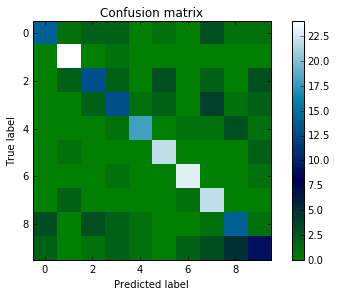

In [34]:
# TODO this is temp code, remove later.
trX, teX, trY, teY = train_test_split(X, Y, stratify=Y)
rf.fit(trX, trY)
plot_confusion_matrix(confusion_matrix(teY, rf.predict(teX))) # pretty different confusion!

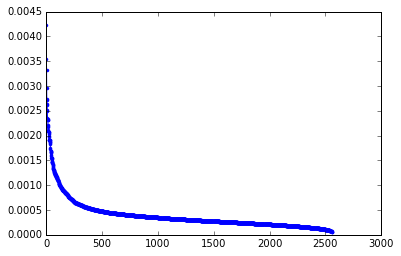

In [59]:
rf.fit(X, Y) # can't technically do whole, integrate this with CV
def order(x):
    p = [x[0] for x in sorted(list(enumerate(x)), key=lambda tup:tup[1])]
    p.reverse()
    return p
p = order(rf.feature_importances_)
plt.plot(rf.feature_importances_[p], '.-')
plt.show()

In [ ]:
print('RF-cutoff mfcc/chroma + SVM (hyper is C regularizer)')
run(whiten(X[:, p[:1000]]), Y, log_range(0, 10), lambda C: SVC(C=C))
print('RF-cutoff mfcc/chroma + poly SVM (hyper is C regularizer)')
run(whiten(X[:, p[:1000]]), Y, log_range(0, 10),
    lambda C: SVC(C=C, kernel='poly', degree=10, coef0=1))
print('RF-cutoff mfcc/chroma + linear SVM (hyper is C regularizer)')
run(whiten(X[:, p[:1000]]), Y, log_range(0, 10),
    lambda C: SVC(C=C, kernel='linear'))
print('RF-scaled mfcc/chroma + rbf SVM (hyper is C regularizer)')
run(rf.feature_importances_ * 1000 * whiten(X), Y, log_range(0, 10), lambda C: SVC(C=C))
print('RF-scaled mfcc/chroma + poly SVM (hyper is C regularizer)')
run(rf.feature_importances_ * 1000 * whiten(X), Y, log_range(0, 10),
    lambda C: SVC(C=C, kernel='poly', degree=10, coef0=1))
print('RF-scaled mfcc/chroma + linear SVM (hyper is C regularizer)')
run(rf.feature_importances_ * 1000 * whiten(X), Y, log_range(0, 10),
    lambda C: SVC(C=C, kernel='linear'))

Using existing FVs from file ../generated-fv/FV8-3.mat
N = 1000
MFCC training feature ranges means [-0.0119, 0.0060] sds [0.0119, 0.0429]
Using existing FVs from file ../generated-fv/FVC8-3.mat
N = 1000
chroma training feature ranges means [-0.0079, 0.0084] sds [0.0170, 0.0492]
voting score 0.716


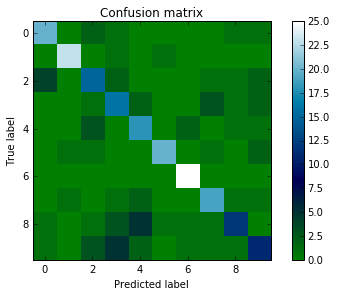

In [63]:
X, Y = load_all_fv(8, 3)
C, Y = load_chroma_fv(8, 3)
from sklearn.ensemble import VotingClassifier

trX, teX, trC, teC, trY, teY = train_test_split(X, C, Y, stratify=Y)

mfccSVM = SVC(C=1000, probability=True)
chromaSVM = SVC(C=1000, probability=True)
mfccRF = RandomForestClassifier(n_estimators=200, max_depth=30)
chromaRF = RandomForestClassifier(n_estimators=200, max_depth=30)
ests = [('mfccSVM', mfccSVM), ('chromaSVM', chromaSVM), ('mfccRF', mfccRF), ('chromaRF', chromaRF)]

mfccRF.fit(trX, trY)
chromaRF.fit(trC, trY)

top_mfcc = order(mfccRF.feature_importances_)
top_chroma = order(chromaRF.feature_importances_)

trX, teX = trX[:, top_mfcc[:1000]], teX[:, top_mfcc[:1000]]
#trC, teC = trC[:, top_chroma[:400]], teC[:, top_chroma[:400]]
mfccSVM.fit(trX, trY)
chromaSVM.fit(trC, trY)

sum_p = sum((2 * mfccSVM.predict_proba(teX), chromaSVM.predict_proba(teC), chromaRF.predict_proba(teC)))
Yhat = np.argmax(sum_p, axis=1) + 1
print('voting score', np.sum(Yhat == teY) / len(teY))
plot_confusion_matrix(confusion_matrix(teY, Yhat))
plt.show()

RF-cutoff mfcc + rbf SVM (hyper is C regularizer)
[--------------------] 1/1 best acc 0.535176 hyper 5
done in 0.8084800243377686 seconds
[--------------------] 1/1 best acc 0.588462 hyper 5
done in 0.990833044052124 seconds
[--------------------] 1/1 best acc 0.639904 hyper 5
done in 1.398914098739624 seconds
[--------------------] 1/1 best acc 0.667067 hyper 5
done in 1.706181526184082 seconds
[--------------------] 1/1 best acc 0.683173 hyper 5
done in 2.213334083557129 seconds
[--------------------] 1/1 best acc 0.694952 hyper 5
done in 2.5045533180236816 seconds
[--------------------] 1/1 best acc 0.712821 hyper 5
done in 3.2288362979888916 seconds
[--------------------] 1/1 best acc 0.715946 hyper 5
done in 3.5558834075927734 seconds
[--------------------] 1/1 best acc 0.714824 hyper 5
done in 3.6879754066467285 seconds
[--------------------] 1/1 best acc 0.720753 hyper 5
done in 4.029447078704834 seconds
[--------------------] 1/1 best acc 0.71875 hyper 5
done in 4.9164564609527

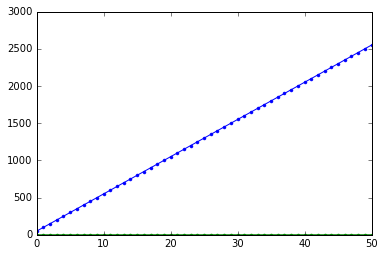

In [16]:
def runRBF5(X, k):
    print('RF-cutoff mfcc + rbf SVM (hyper is C regularizer), cutoff', k)
    return run(whiten(X[:, p[:k]]), Y, [5], lambda C: SVC(C=C))
print('RF-cutoff mfcc + rbf SVM (hyper is C regularizer)')
ks = list(range(50, X.shape[1], 50))
res = [runRBF5(X, k)[0] for k in ks]

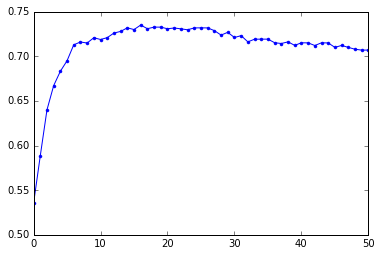

In [19]:
plt.plot(res, '.-')

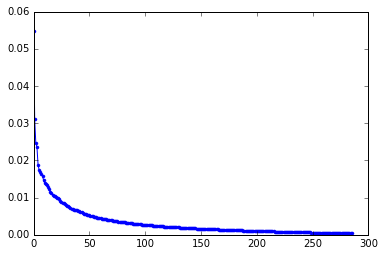

In [49]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True, n_components=0.99).fit(trXrff)
plt.plot(pca.explained_variance_ratio_, '.-')
plt.show()

# PCA shows that all features are pretty important, there's little room for additional dimensional reduction

In [2]:
D = load_all_nonmfc()
for k, v in D.items():
    print(k, v.shape, np.any(np.isnan(v)))

Read in eng for all genres
Read in chroma for all genres
Read in t for all genres
Read in keystrength for all genres
Read in brightness for all genres
Read in zerocross for all genres
Read in roughness for all genres
Read in inharmonic for all genres
Read in hcdf for all genres
keystrength (1000, 12, 1222) False
inharmonic (1000, 1222) True
chroma (1000, 12, 1222) False
brightness (1000, 1222) False
eng (1000, 1222) False
zerocross (1000, 1222) False
t (1000, 1222) False
hcdf (1000, 1222) False
roughness (1000, 1222) False


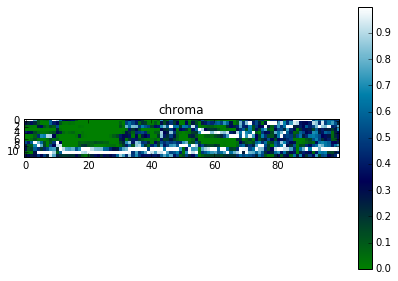

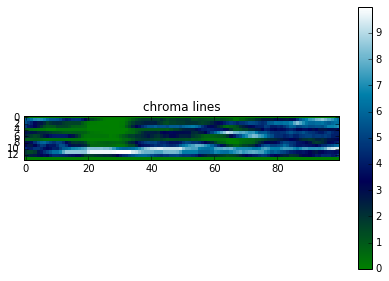

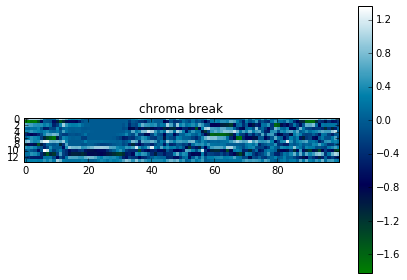

In [38]:
plot_matrix(D['chroma'][0][:,300:400], 'chroma')
plt.show()
#plot_matrix(D['chroma'][1][:,300:400], 'chroma')
#plt.show()

line_finder = [np.zeros(10),
               np.repeat(1, 10),
               np.zeros(10)]
pattern_break = [[0, 0, 1], [0, -1, -1], [0, 0, 1]]
from scipy.signal import convolve2d

plot_matrix(convolve2d(D['chroma'][0], line_finder)[:,300:400], 'chroma lines')
plt.show()
plot_matrix(convolve2d(D['chroma'][0], pattern_break)[:,300:400], 'chroma break')
plt.show()

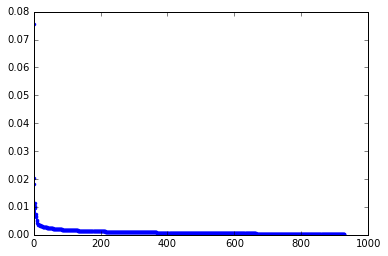

In [50]:
flat_chroma = D['chroma'].reshape(1000, D['chroma'].size // 1000)
pca = PCA(whiten=True, n_components=0.99).fit(flat_chroma)
plt.plot(pca.explained_variance_ratio_, '.-')
plt.show() #roughness, hcdf, eng, brightness, zerocross

0.209084131715


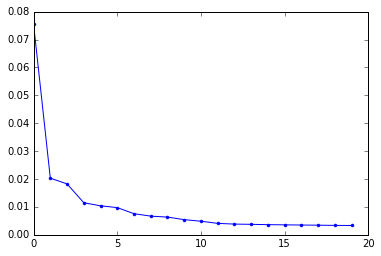

In [54]:
plt.plot(pca.explained_variance_ratio_[:20], '.-')
print(sum(pca.explained_variance_ratio_[:20]))
plt.show()

In [55]:
pca = PCA(whiten=True, n_components=0.20).fit(flat_chroma)
pca_chroma = pca.transform(flat_chroma)
pca_chroma.shape

(1000, 18)

In [68]:
D['roughness'].shape

(1000, 1222)

In [82]:
num_clusters, exemplar = 8, 3
X, Y = load_all_fv(num_clusters, exemplar)
T = num_clusters * 2
t = (exemplar - (1 if exemplar % 2 == 0 else 0)) * 2 - 1
#D['FV'] = np.average(riffle(fvs, t, T), axis=2)

Using existing FVs from file ../generated-fv/FV8-3.mat
N = 1000
MFCC training feature ranges means [-0.0119, 0.0060] sds [0.0119, 0.0429]


In [83]:
def logRange(lo, hi): return [10 ** i for i in range(lo, hi)]
Cs = logRange(0, 10)
kernels = ['rbf']
hypers = list(itertools.product(Cs, kernels))

def print_svc(C, k): return 'C={:03g} kernel={}'.format(C, k)
def make_svc(C, k):
    if k == 'poly': return SVC(C=C, kernel=k, coef0=1.0, degree=5)
    else: return SVC(C=C, kernel=k)

best_acc, best_params = -np.inf, None
t = time.time()
skf = StratifiedKFold(Y, n_folds=4, shuffle=True, random_state=1)
for i, tup in enumerate(hypers):
    svm = make_svc(*tup)
    score = np.average(cross_val_score(svm, X, Y, cv=skf, n_jobs=-1))
    if score > best_acc:
        best_acc = score
        best_params = tup
    print('\r{} best acc {:03g} param {}'.format(
            completion_bar(i + 1, len(hypers), width=10), best_acc,
            print_svc(*best_params)), end='')
    sys.stdout.flush()
t = time.time() - t

svm = make_svc(*best_params)
print('\nDone with CV for {}-size hyper grid in {:03f}s'.format(
        len(hypers), t))
print('Accuracies: best avg cv {} for {}'.format(best_acc, print_svc(*best_params)))

[----------] 10/10 best acc 0.699 param C=1000 kernel=rbf
Done with CV for 10-size hyper grid in 65.772017s
Accuracies: best avg cv 0.6990000000000001 for C=1000 kernel=rbf


In [72]:
svms = ['FV', 'eng', 'hcdf', 'brightness']
rf = ['zerocross', 'roughness']
def tail(it):
    next(it)
    return it
categories, arrs = zip(*sorted(list((k, v) for k, v in D.items() if k in set(svms + rf))))
ends = [0] + list(itertools.accumulate(a.shape[1] for a in arrs))
ends = zip(ends, ends[1:])
excerpts = dict(zip(categories, ends))
X = np.concatenate(arrs, axis=1)

In [79]:
class SVCSub(SVC):
    def __init__(self, name):
        super(SVCSub, self).__init__(probability=True)
        self.name = name
    def fit(self, X, Y):
        super(SVCSub, self).fit(X[:,slice(*excerpts[self.name])], Y)
        return self
    def predict_proba(self, X):
        return super(SVCSub, self).predict_proba(X[:,slice(*excerpts[self.name])])
class RFSub(RandomForestClassifier):
    def __init__(self, name, md, ne):
        if not md: md = 10
        if not ne: ne = 50
        super(RFSub, self).__init__(max_depth=md, n_estimators=ne)
        self.name = name
    def fit(self, X, Y):
        super(RFSub, self).fit(X[:,slice(*excerpts[self.name])], Y)
        return self
    def predict_proba(self, X):
        return super(RFSub, self).predict_proba(X[:,slice(*excerpts[self.name])])
def make_classifier(name):
    if name == 'zerocross': return RFSub(name, 10, 50)
    if name == 'roughness': return RFSub(name, 20, 200)
    return SVCSub(name)

In [81]:
from sklearn.ensemble import VotingClassifier

ests = [(s, make_classifier(s)) for s in svms+rf+['FV'] * 3]
print([s[1].name for s in ests])
c = VotingClassifier(estimators=ests, voting='soft')
skf = StratifiedKFold(Y, n_folds=8, shuffle=True, random_state=1)
np.average(cross_val_score(c, X, Y, cv=skf, n_jobs=-1))
# todo this, then FV on chroma

['FV', 'eng', 'hcdf', 'brightness', 'zerocross', 'roughness', 'FV', 'FV', 'FV']


array([ 0.46923077,  0.40769231,  0.50769231,  0.47692308,  0.48333333,
        0.41666667,  0.46666667,  0.5       ])

In [152]:
#svm1 = findSVC(D['FV'][p][:800], Y[p][:800], 'FV')
 #roughness (RF depth 20 200 learners), hcdf, eng, brightness, zerocross* -> dtree. Also do chroma pca classifier.
#svm2 = findSVC(D['eng'][p][:800], Y[p][:800], 'eng')
#svm3 = findSVC(D['hcdf'][p][:800], Y[p][:800], 'hcdf')
svm4 = findSVC(D['brightness'][p][:800], Y[p][:800], 'brightness')
svm4 = findSVC(D['zerocross'][p][:800], Y[p][:800], 'zerocross')

print(RandomForestClassifier(max_depth=20, n_estimators=200).fit(D['roughness'][p][:800], Y[p][:800]).score(
    D['roughness'][p][800:], Y[p][800:]))

RandomForestClassifier(max_depth=10, n_estimators=50).fit(D['zerocross'][p][:800], Y[p][:800]).score(
    D['zerocross'][p][800:], Y[p][800:])

brightness classifier with cv 0.270038
zerocross classifier with cv 0.122438
0.34


0.28499999999999998

In [131]:
outs = np.concatenate([x.decision_function(D[y][p]) for x, y in zip((svm1, svm2, svm3), ('FV', 'eng', 'hcdf'))],
                       axis=1)
outs.shape

(1000, 135)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

#dt = DecisionTreeClassifier(criterion='gini')
dt= LogisticRegressionCV(multi_class='multinomial')
#dt =SVC(C=1.0, kernel='poly', coef0=1, degree=10)
dt.fit(outs[800:900], Y[p][800:900])
print('train score {} test score {}'.format(dt.score(outs[800:900], Y[p][800:900]), dt.score(outs[900:], Y[p][900:])))

NameError: name 'outs' is not defined

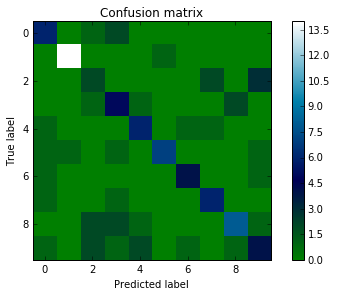

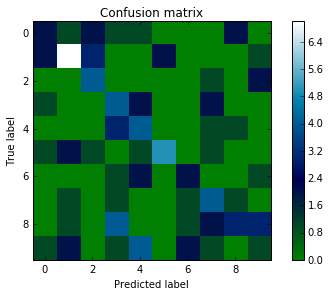

In [66]:
predictions = SVC(C=1.0).fit(trXrff, trY).predict(teXrff)
plot_confusion_matrix(confusion_matrix(teY, predictions))
plt.show()

trXch, teXch = np.split(flat_chroma[p], [int(0.9 * len(X))])
pca_part = PCA(whiten=True, n_components=0.20).fit(trXch)
predictions = SVC(C=1.0).fit(pca.transform(trXch), trY).predict(
    pca.transform(teXch))
plot_confusion_matrix(confusion_matrix(teY, predictions))

Below is a bunch of random classifiers also attempted

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# ovo multi-classification, rbf
if sklearn.__version__ >= '0.18':
    print('warning, not ovo comparison')
svm = SVC(C=1.0)
svm.fit(trXadj, trY)
print('svm Orig accuracies: train {} test {}'.format(svm.score(trXadj, trY), svm.score(teXadj, teY)))
svm.fit(trXrff, trY)
print('svm Red accuracies: train {} test {}'.format(svm.score(trXrff, trY), svm.score(teXrff, teY)))

from sklearn.linear_model import LogisticRegressionCV
reg = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', max_iter=5000, n_jobs=8, cv=8)
reg.fit(trXadj, trY)
print('softmax Orig accuracies: train {} test {}'.format(reg.score(trXadj, trY), reg.score(teXadj, teY)))
reg.fit(trXrff, trY)
print('softmax Orig accuracies: train {} test {}'.format(reg.score(trXrff, trY), reg.score(teXrff, teY)))

In [ ]:
Ngnb = SVC(probability=True)
stumps = AdaBoostClassifier(n_estimators=30, base_estimator=gnb)
stumps.fit(trXadj, trY)
print('Orig accuracies: train {} test {}'.format(stumps.score(trXadj, trY), stumps.score(teXadj, teY)))
stumps.fit(trXred, trY)
print('Red accuracies: train {} test {}'.format(stumps.score(trXred, trY), stumps.score(teXred, teY)))

In [ ]:
v = trXred[0]
def sqmat(x):
    tx = x.reshape((1, len(x)))
    xt = x.reshape((len(x), 1))
    return np.dot(xt, tx).reshape(len(x) * len(x))
sq = np.array([sqmat(x) for x in trXred])
sqt = np.array([sqmat(x) for x in teXred])
print(sq.shape, sqt.shape)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(sq, trY)
gnb.score(sqt, teY)
svm.fit(sq, trY)
print('Accuracies: train {} test {}'.format(svm.score(sq, trY), svm.score(sqt, teY)))

In [ ]:
# Stanford mSVM http://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html
# This requires a new convex program formulation, unsupported within-python.

In [ ]:
class DummyPredictor:
    def __init__(self, res):
        self._res = res
    def predict(self, X):
        Y = np.empty([len(X), 1])
        Y.fill(self._res)
        return Y
        
def find_best(subsets, X, origY, C):
    best_accuracy, best_classifier, best_set = -np.inf, None, None
    val = int(0.8 * len(X))
    for subset in subsets:
        Y = np.array([y in subset for y in origY])
        svm = SVC(C=C).fit(X[:val], Y[:val])
        acc = svm.score(X[val:], Y[val:])
        if acc > best_accuracy:
            best_accuracy = acc
            best_classifier = svm
            best_set = subset
    return best_accuracy, best_classifier, best_set
    
def best_subset_finder(labels, C=1.0):
    assert len(labels) > 0
    if len(labels) == 1:
        return {}, DummyPredictor(next(iter(labels))), {}
    if len(labels) == 2:
        return {}, SVC(C=C).fit(trXadj, trY), {}
    
    subsets = []
    for i in range(1, len(labels) // 2 + 1):
        for subset in itertools.combinations(labels, i):
            subsets.append(subset)
    p = np.random.permutation(len(trXadj))
    pX = trXadj[p]
    pY = trY[p]
    
    nproc = 4
    print('  Launching {} parallel tasks for {} problems.'.format(nproc, len(subsets)))
    sys.stdout.flush()
    np.random.shuffle(subsets)
    
    best_parallel = Parallel(n_jobs=2, backend='threading') \
        (delayed(find_best)(i, pX, pY, C) for i in chunks(subsets, max(len(subsets) // nproc, 1)))
    best_accuracy, best_set, best_classifier = -np.inf, None, None
    for job_best_acc, job_best_classifier, job_best_set in best_parallel:
         if job_best_acc > best_accuracy:
             best_accuracy = job_best_acc
             best_classifier = job_best_classifier
             best_set = set(job_best_set)
         
    other = labels - best_set
    print('  Split on 0/1 for {} vs {}, validation acc {}'.format(
        best_set, other, best_accuracy))
    sys.stdout.flush()
    assert best_classifier
    return best_set, best_classifier, other

class DTree(object):
    def __init__(self, classifier, lset, rset):
        self.lset = lset
        self.rset = rset
        self.left = None
        self.right = None
        self.classifier = classifier

def binary_dtree(labels, C=10.0, debug_print_level=None):
    dbp = debug_print_level
    if dbp: print('Level {}'.format(dbp))
    left, svm, right = best_subset_finder(labels)
    if not left: assert not right
    x = DTree(svm, left, right)
    if not left: return x
    x.left = binary_dtree(left, C=(C * len(left) / len(labels)),
                          debug_print_level=(dbp + '0' if dbp else None))
    x.right = binary_dtree(right, C=(C * len(right) / len(labels)),
                           debug_print_level=(dbp + '1' if dbp else None))
    return x

In [ ]:
bdt = binary_dtree(set(trY), C=10.0, debug_print_level='r')

In [ ]:
#What if we retrain on the whole training dataset?
def dtree_predict(dt, x):
    y = dt.classifier.predict([x])[0]
    if not dt.left: return y
    subtree = dt.left if y else dt.right
    return dtree_predict(subtree, x)

def vec_dtree_predict(dt, X):
    return np.array([dtree_predict(dt, x) for x in X])

np.sum(vec_dtree_predict(bdt, teXadj) == teY) / len(teY)